In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import sys
import pydot

from sklearn.model_selection import train_test_split
from tqdm import tqdm
from IPython.display import SVG
from keras.utils import plot_model
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import AUC
from keras.layers import Lambda,Reshape,Input,Embedding,Dense,Flatten,Activation,concatenate,dot,add,multiply,subtract,Dropout
from keras.models import Model
from tensorflow.keras.preprocessing import sequence
from keras.layers.advanced_activations import PReLU,ReLU
from keras.regularizers import l2 as l2_reg
from sklearn.preprocessing import LabelEncoder,StandardScaler
from keras import backend as K

Using TensorFlow backend.


In [2]:
#train = pd.read_csv('train_merge_data.csv', index_col=0)
#test = pd.read_csv('test_merge_data.csv',index_col=0)
Train = pd.read_csv('train_job/train.csv')
Test = pd.read_csv('test_job.csv')
tags = pd.read_csv('train_job/tags.csv')
user_tags = pd.read_csv('train_job/user_tags.csv')
job_tags = pd.read_csv('train_job/job_tags.csv')
company = pd.read_csv('train_job/job_companies.csv')

In [3]:
data = pd.concat([Test,Train.drop(columns='applied')])

In [4]:
company.companySize.fillna('?',inplace=True)

In [5]:
Train.head(3)

,userID,jobID,applied
0,fe292163d06253b716e9a0099b42031d,15de21c670ae7c3f6f3f1f37029303c9,0
1,6377fa90618fae77571e8dc90d98d409,55b37c5c270e5d84c793e486d798c01d,0
2,8ec0888a5b04139be0dfe942c7eb4199,0fcbc61acd0479dc77e3cccc0f5ffca7,1


In [6]:
Test.head(3)

,userID,jobID
0,ebaee1af0c501f22ddfe242fc16dae53,352407221afb776e3143e8a1a0577885
1,9ab05403ac7808cbfba3da26665f7a9c,96b9bff013acedfb1d140579e2fbeb63
2,33349e909eba71677299d2fc97e158b7,58d4d1e7b1e97b258c9ed0b37e02d087


In [7]:
tags.head(3)

,tagID,keyword
0,602d1305678a8d5fdb372271e980da6a,Amazon Web Services(AWS)
1,e3251075554389fe91d17a794861d47b,Tensorflow
2,a1d50185e7426cbb0acad1e6ca74b9aa,Docker


In [8]:
user_tags.head(3)

,userID,tagID
0,e576423831e043f7928d9ac113abbe6f,82c2559140b95ccda9c6ca4a8b981f1e
1,e576423831e043f7928d9ac113abbe6f,2ba8698b79439589fdd2b0f7218d8b07
2,e576423831e043f7928d9ac113abbe6f,351b33587c5fdd93bd42ef7ac9995a28


In [9]:
job_tags.head(3)

,jobID,tagID
0,320722549d1751cf3f247855f937b982,d38901788c533e8286cb6400b40b386d
1,e744f91c29ec99f0e662c9177946c627,3948ead63a9f2944218de038d8934305
2,e744f91c29ec99f0e662c9177946c627,0e095e054ee94774d6a496099eb1cf6a


In [10]:
jobIDs = data.jobID.unique()
userIDs = data.userID.unique()
tagIDs = tags.tagID.unique()
companyIDs = company.companyID.unique()

jobID_encoder = LabelEncoder(); jobID_encoder.fit(jobIDs)
userID_encoder = LabelEncoder(); userID_encoder.fit(userIDs)
tagID_encoder = LabelEncoder(); tagID_encoder.fit(tagIDs)
companyID_encoder = LabelEncoder(); companyID_encoder.fit(companyIDs)
companySize_encoder = LabelEncoder()

uniq_tagID = tagID_encoder.transform(tagIDs)

company.jobID = jobID_encoder.transform(company.jobID)
company.companyID = companyID_encoder.transform(company.companyID)
company.companySize = companySize_encoder.fit_transform(company.companySize)

user_tags.userID = userID_encoder.transform(user_tags.userID)
user_tags.tagID = tagID_encoder.transform(user_tags.tagID)

job_tags.jobID = jobID_encoder.transform(job_tags.jobID)
job_tags.tagID = tagID_encoder.transform(job_tags.tagID)

def get_userTags(uid):
    return list(user_tags[user_tags.userID==uid].tagID.unique())
def get_jobTags(jid):
    return list(job_tags[job_tags.jobID==jid].tagID.unique())
def get_matchTags(df):
    return np.array(list(set(df.userTags)&set(df.jobTags)))
def get_matchTagsPer(df):
    # user tag중 job tag와 겹치는 tag 비율
    return len(df['matchTags'])/len(set(df.userTags))

def preprocess(df):
    df['userID'] = userID_encoder.transform(df['userID'])
    df['jobID'] = jobID_encoder.transform(df['jobID'])
    df['userTags'] = df.userID.apply(lambda x:get_userTags(x))
    df['jobTags'] = df.jobID.apply(lambda x:get_jobTags(x))
    df['matchTags'] = df.apply(get_matchTags,axis=1)
    df['matchTagsPer'] = df.apply(get_matchTagsPer,axis=1)
    df['anyMatch'] = df['matchTags'].apply(lambda x: 1 if len(x)>0 else 0)
    df = df.merge(company, how='left', on='jobID')
    return df

In [11]:
Train = preprocess(Train)
Test = preprocess(Test)

max_len = 0
for i in pd.concat([Train,Test])['matchTags'].values:
    max_len = max(len(i),max_len)

C:\Users\moon\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [12]:
#user, job 일치하는 tag padding
def pad_matchTags(df):
    pad = df['matchTags'].values
    return sequence.pad_sequences(pad,padding='post')

train_matchTags = pad_matchTags(Train)
test_matchTags = pad_matchTags(Test)

In [13]:
Train.head()

,userID,jobID,applied,userTags,jobTags,matchTags,matchTagsPer,anyMatch,companyID,companySize
0,195,52,0,"[141, 558, 836, 301, 142, 623, 404, 439, 878, ...","[590, 726]",[],0.000000,0,79,3
1,64,245,0,"[836, 485, 501, 439, 205, 640, 282, 42, 510, 8...","[732, 224, 697]",[697],0.040000,1,141,2
2,111,35,1,"[855, 595, 724, 308, 204, 271, 132]","[212, 595, 378]",[595],0.142857,1,259,7
3,190,177,0,"[396, 855, 423, 709, 77, 595, 42, 204, 224, 78...","[42, 780, 439, 709, 366]","[42, 709, 439]",0.176471,1,146,3
4,159,117,0,"[161, 271, 809, 126, 614, 836, 696, 501, 655, ...","[224, 439, 42, 480]",[42],0.050000,1,195,6


In [14]:
COLUMNS = ['userID','jobID','companyID','companySize','matchTagsPer','anyMatch']
CATEGORY = ['userID','jobID','companyID','anyMatch','companySize']
MUL_CATEGORY = ['matchTags']
CONTINUE = ['matchTagsPer']

In [15]:
train_data = Train[COLUMNS]
test_data = Test[COLUMNS]

In [16]:
train_label = np.array(Train['applied'])

In [17]:
# Category / Continue columns encoding
'''
d = pd.concat([train_data,test_data])
for col in CONTINUE:
    scaler = StandardScaler();
    data[col] = scaler.fit_transform(d[[col]])
    train_data[col] = scaler.transform(train_data[[col]])
    test_data[col] = scaler.transform(test_data[[col]])
    
feature_num={}
for col in CATEGORY:
    le = LabelEncoder(); 
    data[col] = le.fit_transform(data[col])
    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])
    feature_num[col] = data[col].max()
for col in CONTINUE:
    scaler = StandardScaler(); 
    data[col] = scaler.fit_transform(data[[col]])
    train[col] = scaler.transform(train[[col]])
    test[col] = scaler.transform(test[[col]])
'''

'\nd = pd.concat([train_data,test_data])\nfor col in CONTINUE:\n    scaler = StandardScaler();\n    data[col] = scaler.fit_transform(d[[col]])\n    train_data[col] = scaler.transform(train_data[[col]])\n    test_data[col] = scaler.transform(test_data[[col]])\n'

In [19]:
train_data.head()

,userID,jobID,companyID,companySize,matchTagsPer,anyMatch
0,195,52,79,3,0.000000,0
1,64,245,141,2,0.040000,1
2,111,35,259,7,0.142857,1
3,190,177,146,3,0.176471,1
4,159,117,195,6,0.050000,1


In [20]:
train_matchTags

array([[  0,   0,   0, ...,   0,   0,   0],
       [697,   0,   0, ...,   0,   0,   0],
       [595,   0,   0, ...,   0,   0,   0],
       ...,
       [697, 836,   0, ...,   0,   0,   0],
       [439,   0,   0, ...,   0,   0,   0],
       [440,   0,   0, ...,   0,   0,   0]])

In [21]:
test_data.head(3)

,userID,jobID,companyID,companySize,matchTagsPer,anyMatch
0,180,157,193,3,0.230769,1
1,121,420,168,6,0.083333,1
2,29,252,111,3,0.166667,1


In [22]:
test_matchTags

array([[204, 141, 423, ...,   0,   0,   0],
       [204,   0,   0, ...,   0,   0,   0],
       [ 42,   0,   0, ...,   0,   0,   0],
       ...,
       [202, 836,   0, ...,   0,   0,   0],
       [595,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

In [23]:
Train.to_csv('preprocessed_Train.csv',index=False)
Test.to_csv('preprocessed_Test.csv',index=False)

In [24]:
train_category = np.array(train_data[CATEGORY])
test_category = np.array(test_data[CATEGORY])
train_continue = np.array(train_data[CONTINUE])
test_continue = np.array(test_data[CONTINUE])

In [25]:
dim = {}
d = pd.concat([Train,Test])
for col in CATEGORY:
    dim[col] = len(d[col].unique())

C:\Users\moon\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [26]:
# test data의 label값이 없어서, 임의로 train/test set 나눔

x_test = Train.sample(frac=0.15,random_state=2021)
x_train = Train.drop(x_test.index)

train_label = np.array(x_train['applied'])
train_category = np.array(x_train[CATEGORY])
train_continue = np.array(x_train[CONTINUE])
train_matchTags = pad_matchTags(x_train)

test_label = np.array(x_test['applied'])
test_category = np.array(x_test[CATEGORY])
test_continue = np.array(x_test[CONTINUE])
test_matchTags = pad_matchTags(x_test)

In [29]:
def DeepFM(k=16,deep_dim=256,flag=False):
    inputs = []
    flattens = []
    
    #2nd order FM
    for col in CATEGORY:
        input_ = Input(shape=(1,), name='2nd_input_'+col, dtype='int32')
        embed_ = Embedding(dim[col], k, input_length=1,W_regularizer=l2_reg(0.001), name='2nd_embed_'+col)(input_)
        flatten_ = Flatten(name='flatten_'+col)(embed_)
        inputs.append(input_)
        flattens.append(flatten_)
        
    if flag:
        input_ = Input(shape=(max_len,),dtype='int32')
        embed_ = Embedding(len(uniq_tagID),k, input_length=max_len)(input_)
        flatten_ = Lambda(lambda x: K.mean(x,axis=1))(embed_) # None * max_len * k -> None * k
        inputs.append(input_)
        flattens.append(flatten_)
    
    sum_embeds = add(flattens)
    sum_square_embeds = multiply([sum_embeds,sum_embeds])
    square_embeds = []
    
    for layer in flattens:
        square_embeds.append(multiply([layer,layer]))
    square_sum_embeds = add(square_embeds)
    subtract_layer = subtract([sum_square_embeds,square_sum_embeds])
    second_order = Lambda(lambda x: x*0.5)(subtract_layer)
    second_order = Dropout(0.9)(second_order)
    
    #1st order FM
    layers = []
    for idx,col in enumerate(CATEGORY):
        embed_ = Embedding(dim[col],1,input_length=1,W_regularizer=l2_reg(0.001),name='1st_embed_'+col)(inputs[idx])
        flatten_ = Flatten(name='1st_flatten_'+col)(embed_)
        layers.append(flatten_)
    
    first_order = add(layers)
    first_odrer = BatchNormalization()(first_order)
    first_order = Dropout(0.9)(first_order)
    
    #deep
    continue_input = Input(shape=(len(CONTINUE),),name='input_continue')
    inputs.append(continue_input)
    continue_dense = Dense(deep_dim, use_bias=False)(continue_input)
    
    deep = concatenate(flattens+[continue_dense])
    deep = ReLU()(deep)
    #deep = PReLU()(deep)
    deep = Dropout(rate=0.6)(deep)
    
    deep = Dense(deep_dim)(deep)
    deep = ReLU()(deep)
    #deep = PReLU()(deep)
    deep = Dropout(rate=0.3)(deep)
    
    deep = Dense(deep_dim)(deep)
    deep = ReLU()(deep)
    #deep = PReLU()(deep)
    deep = Dropout(rate=0.2)(deep)
    
    concat_input = concatenate([first_order,second_order,deep])
    outputs = Dense(1, activation='sigmoid')(concat_input)
    
    model = Model(inputs=inputs, outputs=outputs)
    optimizer = optimizers.SGD(lr=0.01, decay=0, momentum=0.01, nesterov=True)
    
    loss = 'binary_crossentropy'
    model.compile(optimizer=optimizer, loss=loss, metrics=[AUC(name='auc')])
    
    return model

In [40]:
model = DeepFM(k=18,deep_dim=48)

C:\Users\moon\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(196, 18, input_length=1, name="2nd_embed_userID", embeddings_regularizer=<keras.reg...)`
  
C:\Users\moon\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(733, 18, input_length=1, name="2nd_embed_jobID", embeddings_regularizer=<keras.reg...)`
  
C:\Users\moon\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(276, 18, input_length=1, name="2nd_embed_companyID", embeddings_regularizer=<keras.reg...)`
  
C:\Users\moon\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(2, 18, input_length=1, name="2nd_embed_anyMatch", embeddings_regularizer=<keras.reg...)`
  
C:\Users\moon\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: Use

In [41]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
2nd_input_userID (InputLayer)   (None, 1)            0                                            
__________________________________________________________________________________________________
2nd_input_jobID (InputLayer)    (None, 1)            0                                            
__________________________________________________________________________________________________
2nd_input_companyID (InputLayer (None, 1)            0                                            
__________________________________________________________________________________________________
2nd_input_anyMatch (InputLayer) (None, 1)            0                                            
____________________________________________________________________________________________

re_lu_6 (ReLU)                  (None, 48)           0           dense_7[0][0]                    
__________________________________________________________________________________________________
1st_embed_userID (Embedding)    (None, 1, 1)         196         2nd_input_userID[0][0]           
__________________________________________________________________________________________________
1st_embed_jobID (Embedding)     (None, 1, 1)         733         2nd_input_jobID[0][0]            
__________________________________________________________________________________________________
1st_embed_companyID (Embedding) (None, 1, 1)         276         2nd_input_companyID[0][0]        
__________________________________________________________________________________________________
1st_embed_anyMatch (Embedding)  (None, 1, 1)         2           2nd_input_anyMatch[0][0]         
__________________________________________________________________________________________________
1st_embed_

In [ ]:
epochs = 4000
batch_size = 256

checkpoint = ModelCheckpoint(filepath='DeepFM.h5', monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=20)


#train_input = [train_category[:,i] for i in range(train_category.shape[1])]+[train_continue]
train_input = [train_category[:,i] for i in range(train_category.shape[1])]+[train_matchTags]+[train_continue]
hist = model.fit(train_input,train_label,epochs = epochs, batch_size=batch_size,validation_split=0.15, callbacks=[checkpoint,early_stopping])

In [ ]:
# model2 : DeepFM without matchTags 
model2 = DeepFM(k=18,deep_dim=48,flag=True)

epochs = 4000
batch_size = 256

checkpoint = ModelCheckpoint(filepath='DeepFM.h5', monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=20)


train_input2 = [train_category[:,i] for i in range(train_category.shape[1])]+[train_continue]
hist2 = model2.fit(train_input2,train_label,epochs = epochs, batch_size=batch_size,validation_split=0.15, callbacks=[checkpoint,early_stopping])


In [45]:
import matplotlib.pyplot as plt
def plt_show(hist):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    #acc_ax.plot(hist.history['auc'], 'b', label='train auc')
    acc_ax.plot(hist.history['val_auc'], 'g', label='val auc')

    #acc_ax.plot(hist.history['accuracy'], 'dodgerblue', label='train acc')
    #acc_ax.plot(hist.history['val_accuracy'], 'springgreen', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper right')


    plt.show()

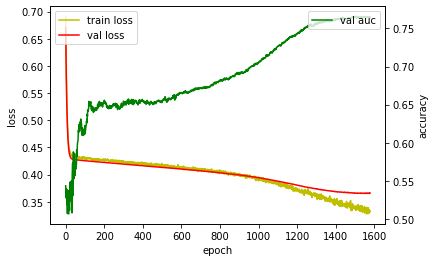

In [46]:
plt_show(hist)

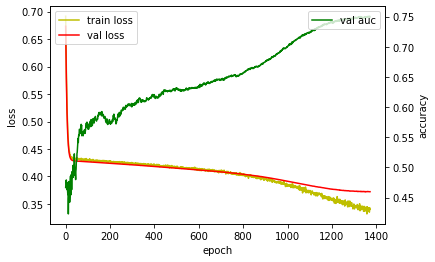

In [47]:
plt_show(hist2)

In [49]:
model.evaluate(train_input,train_label)

5100/5100 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 36us/step


[0.31128618880814196, 0.8698626756668091]

In [48]:
model2.evaluate(train_input2,train_label)

5100/5100 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 35us/step


[0.3199136156428094, 0.8634520769119263]

In [54]:
def chk(test):
    cnt=0
    for i in range(test.shape[0]):
        if x_test.iloc[i].applied == test.iloc[i].pred:
            cnt+=1
    print(cnt/test.shape[0])

In [55]:
#첫번째 모델 평가

test_input = [test_category[:,i] for i in range(test_category.shape[1])]+[test_matchTags]+[test_continue]
test_pred = model.predict(test_input)
pred = pd.DataFrame(test_pred)
pred.columns=['pred']
pred['pred'] = pred['pred'].apply(lambda x: 1 if x>=.5 else 0)

chk(pred)
pred.to_csv('DeepFM_pred.csv',index=False)

0.8711111111111111


In [56]:
#두번째 모델 평가

test_input2 = [test_category[:,i] for i in range(test_category.shape[1])]+[test_continue]
test_pred2 = model2.predict(test_input2)
pred = pd.DataFrame(test_pred2)
pred.columns=['pred']
pred['pred'] = pred['pred'].apply(lambda x: 1 if x>=.5 else 0)
cnt = 0

chk(pred)
pred.to_csv('DeepFM_pred2.csv',index=False)

0.8655555555555555


In [37]:
import gc
gc.collect()

80

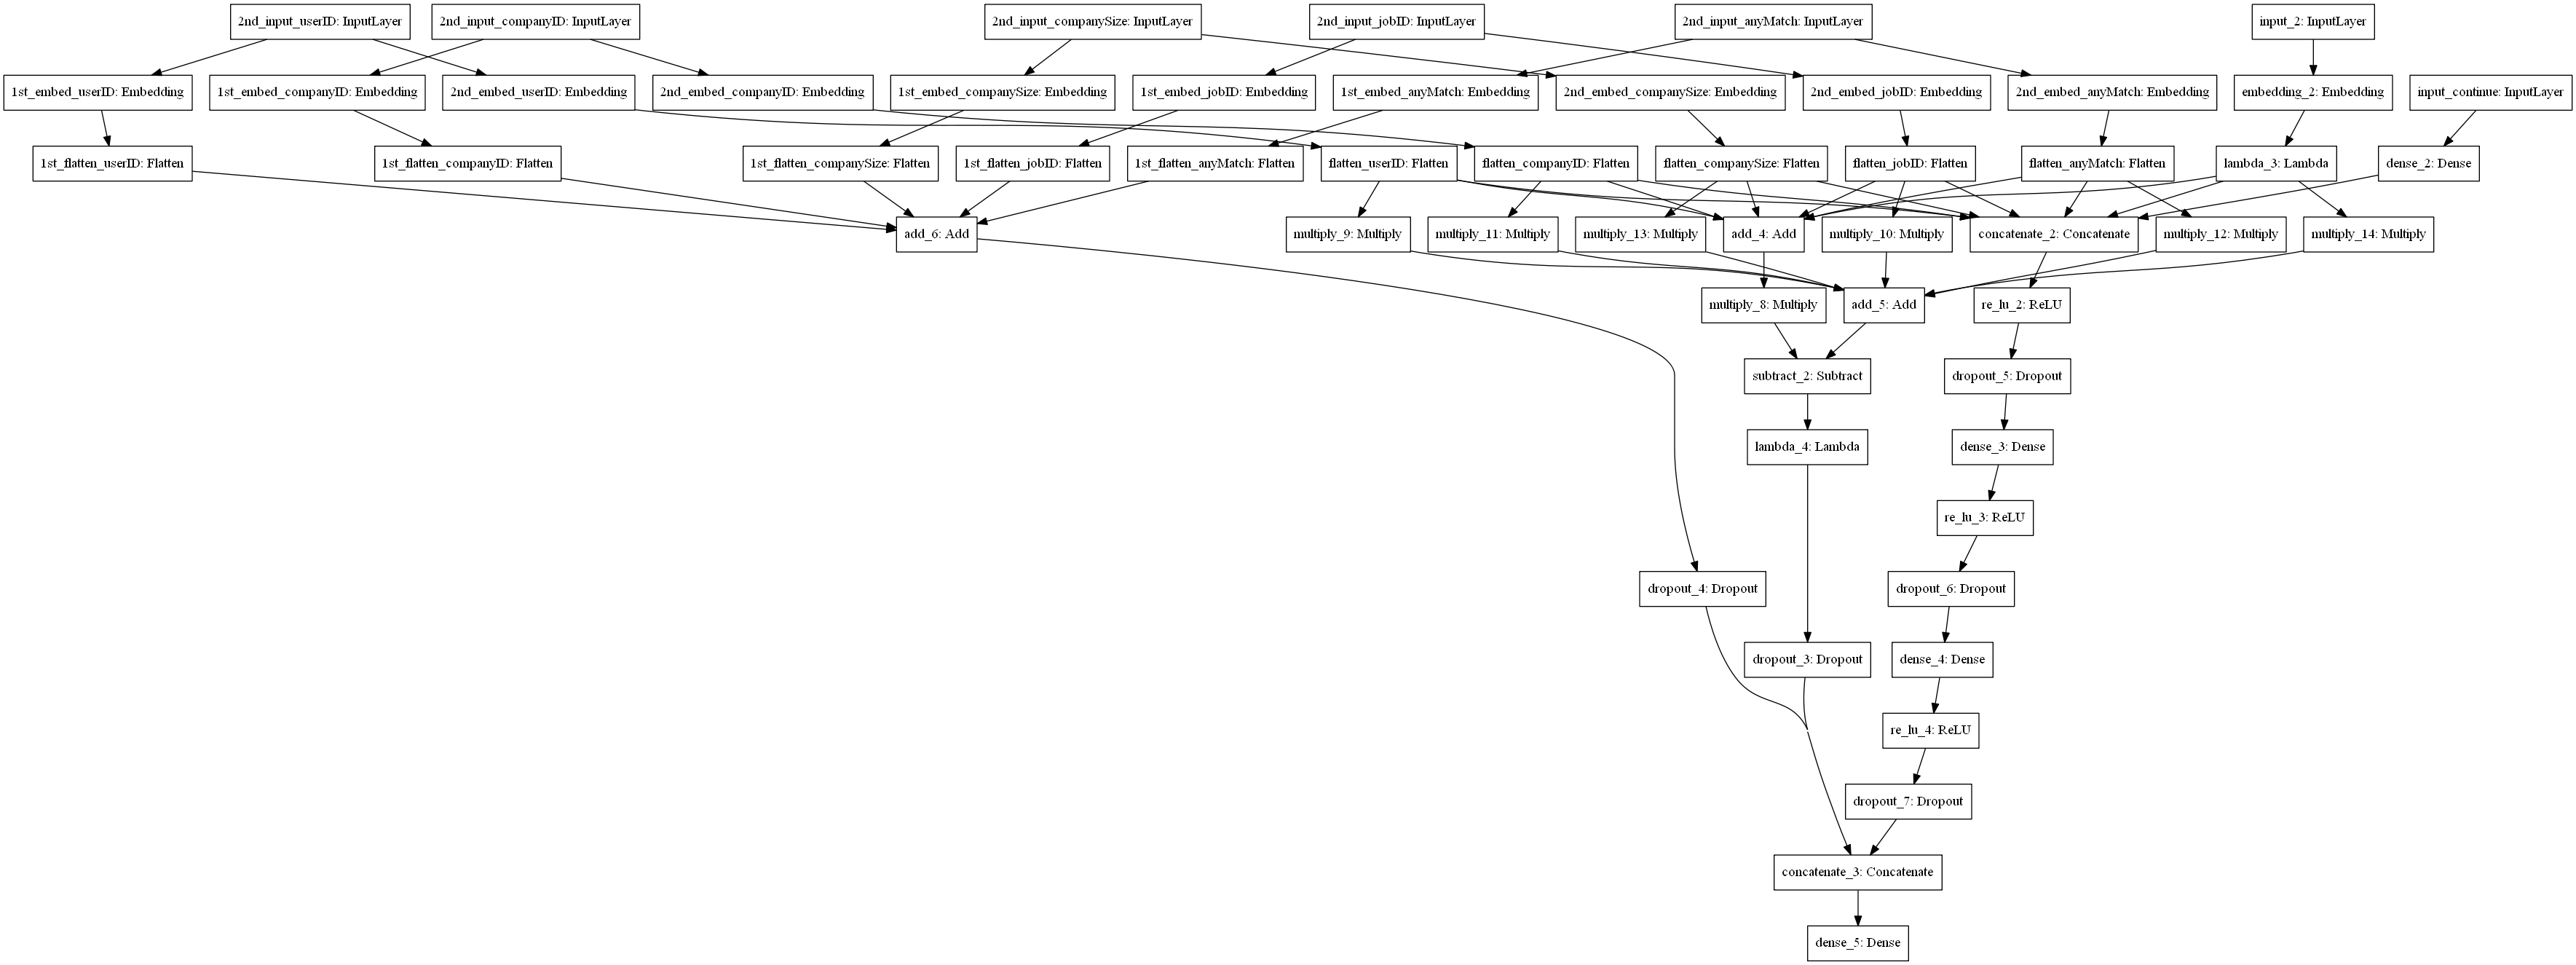

In [38]:
keras.utils.vis_utils.pydot = pydot
plot_model(model,to_file='model.png')